In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
%matplotlib inline
from IPython import display

import random
from scipy.stats import gaussian_kde
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, log_loss, mean_absolute_error, mean_squared_error, brier_score_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

from algorithms import *
from utils import *
from KMPE import *
from NN_functions import *

from torchvision.datasets import MNIST

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings('ignore')

# Data

In [3]:
def read_data(data_mode, truncate=None, random_state=None):
    if data_mode == 'bank':
        df = pd.read_csv('UCI//bank//bank-full.csv', sep=';')
        df['balance'] = normalize_col(df['balance'])
        df = dummy_encode(df)
        df.rename(columns={'y': 'target'}, inplace=True)

    elif data_mode == 'concrete':
        df = pd.read_excel('UCI//concrete//Concrete_Data.xls')
        df = normalize_cols(df)
        df.rename(columns={'Concrete compressive strength(MPa, megapascals) ': 'target'}, inplace=True)
        df['target'] = reg_to_class(df['target'])

    elif data_mode == 'housing':
        df = pd.read_fwf('UCI//housing//housing.data.txt', header=None)
        df = normalize_cols(df)
        df.rename(columns={13: 'target'}, inplace=True)
        df['target'] = reg_to_class(df['target'])

    elif data_mode == 'landsat':
        df = pd.read_csv('UCI//landsat//sat.trn.txt', header=None, sep=' ')
        df = pd.concat([df, pd.read_csv('UCI//landsat//sat.tst.txt', header=None, sep=' ')])
        df = normalize_cols(df, columns=[x for x in range(36)])
        df.rename(columns={36: 'target'}, inplace=True)
        df['target'] = mul_to_bin(df['target'])

    elif data_mode == 'mushroom':
        df = pd.read_csv('UCI//mushroom//agaricus-lepiota.data.txt', header=None)
        df = dummy_encode(df)
        df.rename(columns={0: 'target'}, inplace=True)

    elif data_mode == 'pageblock':
        df = pd.read_fwf('UCI//pageblock//page-blocks.data', header=None)
        df = normalize_cols(df, columns=[x for x in range(10)])
        df.rename(columns={10: 'target'}, inplace=True)
        df['target'] = mul_to_bin(df['target'], 1)

    elif data_mode == 'shuttle':
        df = pd.read_csv('UCI//shuttle//shuttle.trn', header=None, sep=' ')
        df = pd.concat([df, pd.read_csv('UCI//shuttle//shuttle.tst.txt', header=None, sep=' ')])
        df = normalize_cols(df, columns=[x for x in range(9)])
        df.rename(columns={9: 'target'}, inplace=True)
        df['target'] = mul_to_bin(df['target'], 1)

    elif data_mode == 'spambase':
        df = pd.read_csv('UCI//spambase//spambase.data.txt', header=None, sep=',')
        df = normalize_cols(df, columns=[x for x in range(57)])
        df.rename(columns={57: 'target'}, inplace=True)

    elif data_mode == 'wine':
        df = pd.read_csv('UCI//wine//winequality-red.csv', sep=';')
        df_w = pd.read_csv('UCI//wine//winequality-white.csv', sep=';')
        df['target'] = 1
        df_w['target'] = 0
        df = pd.concat([df, df_w])
        df = normalize_cols(df, [x for x in df.columns if x != 'target'])
        
    elif data_mode.startswith('mnist'):
        data = MNIST('mnist', download=True, train=True)
        data_test = MNIST('mnist', download=True, train=False)

        df = data.train_data
        target = data.train_labels
        df_test = data_test.test_data
        target_test = data_test.test_labels

        df = pd.DataFrame(torch.flatten(df, start_dim=1).detach().numpy())
        df_test = pd.DataFrame(torch.flatten(df_test, start_dim=1).detach().numpy())
        df = pd.concat([df, df_test])
        df = normalize_cols(df)
        
        target = pd.Series(target.detach().numpy())
        target_test = pd.Series(target_test.detach().numpy())
        target = pd.concat([target, target_test])
        
        if data_mode == 'mnist_1':
            target[target % 2 == 0] = 0
            target[target != 0] = 1
        elif data_mode == 'mnist_2':
            target[target < 5] = 0
            target[target >= 5] = 1
        elif data_mode == 'mnist_3':
            target[target.isin({0, 3, 5, 6, 7})] = 0
            target[target.isin({1, 2, 4, 8, 9})] = 1
        
        df['target'] = target
        
    # 1 = N, 0 = P
    df['target'] = 1 - df['target']
    
    if truncate is not None and truncate < df.shape[0]:
        if truncate > 1:
            df = df.sample(n=truncate, random_state=random_state)
        elif truncate > 0:
            df = df.sample(frac=truncate, random_state=random_state)
    return df

In [4]:
def make_pu(df, data_mode, alpha=0.5, random_state=None):
    df['target_pu'] = df['target']
    n_pos, n_pos_to_mix, n_neg_to_mix = shapes[data_mode][alpha]
    df_pos = df[df['target'] == 0].sample(n=n_pos+n_pos_to_mix, random_state=random_state, replace=False).reset_index(drop=True)
    df_neg = df[df['target'] == 1].sample(n=n_neg_to_mix, random_state=random_state, replace=False).reset_index(drop=True)
    df_pos.loc[df_pos.sample(n=n_pos_to_mix, random_state=random_state, replace=False).index, 'target_pu'] = 1
    return pd.concat([df_pos, df_neg]).sample(frac=1).reset_index(drop=True)

In [5]:
shapes = {'bank': {0.95: (1000, 200, 3800), 
                   0.75: (1000, 1000, 3000), 
                   0.50: (1000, 2000, 2000), 
                   0.25: (1000, 3000, 1000), 
                   0.05: (1000, 3800, 200)},
          'concrete': {0.95: (462, 28, 540), 
                   0.75: (310, 180, 540), 
                   0.50: (100, 390, 390), 
                   0.25: (100, 390, 130),
                   0.05: (110, 380, 20)},
          'housing': {0.95: (194, 15, 297), 
                   0.75: (110, 99, 297), 
                   0.50: (50, 159, 159),
                   0.25: (50, 159, 53),
                   0.05: (57, 152, 8)},
          'landsat': {0.95: (1217, 189, 3594), 
                   0.75: (1000, 1000, 3000), 
                   0.50: (682, 2159, 2159), 
                   0.25: (501, 2340, 780), 
                   0.05: (504, 2337, 123)},
          'mushroom': {0.95: (1000, 200, 3800), 
                   0.75: (1000, 1000, 3000), 
                   0.50: (1000, 2000, 2000), 
                   0.25: (1000, 2916, 972), 
                   0.05: (990, 2926, 154)},
          'pageblock': {0.95: (326, 234, 4446), 
                   0.75: (100, 460, 1380), 
                   0.50: (100, 460, 460), 
                   0.25: (101, 459, 153), 
                   0.05: (104, 456, 24)},
          'shuttle': {0.95: (1000, 200, 3800), 
                   0.75: (1000, 1000, 3000), 
                   0.50: (1000, 2000, 2000), 
                   0.25: (1000, 3000, 1000), 
                   0.05: (1000, 3800, 200)},
          'spambase': {0.95: (1666, 147, 2788), 
                   0.75: (884, 929, 2788), 
                   0.50: (400, 1413, 1413), 
                   0.25: (400, 1413, 471), 
                   0.05: (407, 1406, 74)},
          'wine': {0.95: (1000, 200, 3800), 
                   0.75: (599, 1000, 3000), 
                   0.50: (400, 1199, 1199), 
                   0.25: (399, 1200, 400), 
                   0.05: (402, 1197, 63)},
          'mnist_1': {0.95: (1000, 200, 3800), 
                   0.75: (1000, 1000, 3000), 
                   0.50: (1000, 2000, 2000), 
                   0.25: (1000, 3000, 1000), 
                   0.05: (1000, 3800, 200)},
          'mnist_2': {0.95: (1000, 200, 3800), 
                   0.75: (1000, 1000, 3000), 
                   0.50: (1000, 2000, 2000), 
                   0.25: (1000, 3000, 1000), 
                   0.05: (1000, 3800, 200)},
          'mnist_3': {0.95: (1000, 200, 3800), 
                   0.75: (1000, 1000, 3000), 
                   0.50: (1000, 2000, 2000), 
                   0.25: (1000, 3000, 1000), 
                   0.05: (1000, 3800, 200)}}

# Code for experiments

In [12]:
# data_mode = 'bank' # 0.11, (5289, 39922, 45211)
# data_mode = 'concrete' # 0.47, (490, 540, 1030)
# data_mode = 'housing' # 0.41, (209, 297, 506)
# data_mode = 'landsat' # 0.44, (2841, 3594, 6435)
# data_mode = 'mushroom' # 0.48, (3916, 4208, 8124)
# data_mode = 'pageblock' # 0.1, (560, 4913, 5473)
# data_mode = 'shuttle' # 0.21, (12414, 45586, 58000)
# data_mode = 'spambase' # 0.39, (1813, 2788, 4601)
# data_mode = 'wine' # 0.24, (1599, 4898, 6497)
# data_mode = 'mnist_1' # 0.51, (35582, 34418, 70000)
data_mode = 'mnist_2'
# data_mode = 'mnist_3'

In [13]:
df = read_data(data_mode, truncate=None)
df = make_pu(df, data_mode, alpha=0.25, random_state=5)
alpha = ((df['target'] == 1).sum() / (df['target_pu'] == 1).sum()).item()

print(df.shape)
print('alpha =', alpha)

(5000, 786)
alpha = 0.05


In [14]:
test_alpha, poster = estimate_poster_cv(df.drop(['target', 'target_pu'], axis=1).values, df['target_pu'].values, 
                                        estimator='en',
                                        estimate_poster_options={'disp': True, 'plot': False, 'estimator': 'e1'},
                                        estimate_diff_options={'bw_mix': 0.05, 'bw_pos': 0.15},
                                        estimate_preds_cv_options={'cv': 3, 'n_networks': 10,
                                                                   'lr': 0.0005, 'hid_dim': 128,
                                                                   'n_hid_layers': 3, 'random_state': 1},
                                        train_nn_options={'n_epochs': 200, 'batch_size': 32,
                                                           'n_batches': 15, 'n_early_stop': 3, 'disp': False})

test_alpha

0

In [15]:
print('log_loss:', 
      log_loss(df.loc[df['target_pu']==1, 'target'], poster))
print('accuracy:', 
      accuracy_score(df.loc[df['target_pu']==1, 'target'], poster.round()))
print('precision:', 
      precision_score(df.loc[df['target_pu']==1, 'target'], poster.round()))
print('recall:', 
      recall_score(df.loc[df['target_pu']==1, 'target'], poster.round()))
print('roc-auc:',
      roc_auc_score(df.loc[df['target_pu']==1, 'target'], poster))

log_loss: 0.7029187997372581
accuracy: 0.7405
precision: 0.10246679316888045
recall: 0.54
roc-auc: 0.6934973684210526


In [5]:
def experiment_uci(datasets=None, alphas=None, n_networks=10, n_rep=10, find_alpha=True):
    """
    :find_alpha: if True, alpha is identified; if False, alpha is considered known and only corresponding 
        posteriors are estimated
    Most parameters, e.g. for implementations of algorithms, are hardcoded - change them in the function.
    """
    
    if alphas is None:
        alphas = [0.05, 0.25, 0.5, 0.75, 0.95]
        
    if datasets is None:
        datasets = ['bank', 'concrete', 'housing', 'landsat', 'mushroom', 'pageblock', 'shuttle', 'spambase', 'wine', 
                    'mnist_1', 'mnist_2', 'mnist_3']
        
    results = []
    fixed_alpha = None
    for dataset in tqdm(datasets):
        if dataset in {'mnist_1', 'mnist_2', 'mnist_3'}:
            n_neurons = 128
            n_layers = 3
        else:
            n_neurons = 64
            n_layers = 2

        for alpha in tqdm(shapes[dataset].keys()):
        
            if alpha not in alphas:
                continue
            
            n_pos, n_pos_to_mix, n_neg_to_mix = shapes[dataset][alpha]
            n_mix = n_pos_to_mix + n_neg_to_mix
            real_alpha = n_neg_to_mix / n_mix
            
            if n_pos < 100:
                batch_size = 2
            elif n_pos < 200:
                batch_size = 4
            elif n_pos < 500:
                batch_size = 8
            else:
                batch_size = 16
            
            for i in range(n_rep):
        
                df = read_data(dataset, truncate=None, random_state=i)
               
                df = make_pu(df, dataset, alpha, random_state=i)
                data = df.drop(['target', 'target_pu'], axis=1).values
            
                target_pu = df['target_pu'].values
                target_mix = df.loc[df['target_pu'] == 1, 'target'].values
                
                if not find_alpha:
                    fixed_alpha = alpha
                res = dict()
                    
                res = estimate_poster_cv(data, target_pu, estimator='ntc_methods', alpha=fixed_alpha,
                                         estimate_poster_options={'disp': False},
                                         estimate_diff_options={'tune': True,
                                                                'tune_diff_options': {'max_evals': 20, 'verbose': False,
                                                                                      'bw_mix_l': 0.01, 'bw_mix_h': 0.15, 
                                                                                      'bw_pos_l': 0.05, 'bw_pos_h': 0.25,
                                                                                      'threshold_l': 0.55, 'threshold_h': 0.55,
                                                                                      'k_neighbours_l': int(n_mix / 25), 
                                                                                      'k_neighbours_h': int(n_mix / 5),
                                                                                      'metric': brier_score_loss, 
                                                                                      'if_round': False,
                                                                                      'reweight': False}},
                                         estimate_preds_cv_options={'cv': 3, 'n_networks': n_networks,
                                                                    'lr': 0.0005, 'hid_dim': n_neurons,
                                                                    'n_hid_layers': n_layers, 
                                                                    'random_state': n_networks*i},
                                         train_nn_options={'n_epochs': 200, 'batch_size': batch_size,
                                                           'n_batches': 15, 'n_early_stop': 3, 'disp': False})
                
#                 res['nnre'] = estimate_poster_cv(data, target_pu, estimator='nnre', alpha=real_alpha,
#                                                  estimate_preds_cv_options={'cv': 3, 'n_networks': n_networks,
#                                                                             'lr': 0.0005, 'hid_dim': n_neurons,
#                                                                             'n_hid_layers': n_layers, 
#                                                                             'random_state': n_networks*i},
#                                                  train_nn_options={'n_epochs': 100, 'batch_size': batch_size, 
#                                                                    'n_batches': 15, 'loss_function': 'brier',
#                                                                    'n_early_stop': 5, 'disp': False})
                for key in res.keys():
                    est_alpha, poster = res[key]

                    cur_result = [dataset, key, i, n_mix, n_pos, alpha, real_alpha, est_alpha]
                    cur_result.append(np.mean(poster))
                    cur_result.append(accuracy_score(target_mix, poster.round()))
                    cur_result.append(roc_auc_score(target_mix, poster))
                    cur_result.append(log_loss(target_mix, poster))
                    cur_result.append(precision_score(target_mix, poster.round()))
                    cur_result.append(recall_score(target_mix, poster.round()))
                    cur_result.append(balanced_accuracy_score(target_mix, poster.round()))
                    cur_result.append(brier_score_loss(target_mix, poster))
                    weights = np.full(poster.shape, target_mix.mean())
                    weights[target_mix == 1] = 1 - target_mix.mean()
                    cur_result.append(brier_score_loss(target_mix, poster, sample_weight=weights))
                    
                    results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['dataset', 'estimator', 'random_state', 
                                                'n_mix', 'n_pos', 'alpha', 'real_alpha', 'est_alpha', 'mean_poster',
                                                'accuracy', 'roc', 'log_loss', 'precision', 'recall', 
                                                'accuracy_balanced', 'brier_score', 'balanced_brier_score'])
    return df_results

In [6]:
res = experiment_uci(find_alpha=False)
# res = experiment_uci(find_alpha=True)
res = res.round(5)

res.to_csv('experiment_uci_mnist_poster.csv', index=False, sep=';', decimal=',')

## KM

implementation is taken from http://web.eecs.umich.edu/~cscott/code.html#kmpe

In [36]:
# data_mode = 'bank' # 0.11, (5289, 39922, 45211)
# data_mode = 'concrete' # 0.47, (490, 540, 1030)
# data_mode = 'housing' # 0.41, (209, 297, 506)
# data_mode = 'landsat' # 0.44, (2841, 3594, 6435)
data_mode = 'mushroom' # 0.48, (3916, 4208, 8124)
# data_mode = 'pageblock' # 0.1, (560, 4913, 5473)
# data_mode = 'shuttle' # 0.21, (12414, 45586, 58000)
# data_mode = 'spambase' # 0.39, (1813, 2788, 4601)
# data_mode = 'wine' # 0.24, (1599, 4898, 6497)
# data_mode = 'mnist_1' # 0.51, (35582, 34418, 70000)
# data_mode = 'mnist_2'
# data_mode = 'mnist_3'

In [40]:
df = read_data(data_mode, truncate=None)
df = make_pu(df, data_mode, alpha=0.05, random_state=5)
alpha = ((df['target'] == 1).sum() / (df['target_pu'] == 1).sum()).item()

print(df.shape)
print('alpha =', alpha)

(4070, 24)
alpha = 0.05


In [42]:
KM_2 = wrapper(df[df['target_pu'] == 1].drop(['target', 'target_pu'], axis=1).values, 
               df[df['target_pu'] == 0].drop(['target', 'target_pu'], axis=1).values, 
               epsilon=0.04, lambda_lower_bound=0.5, lambda_upper_bound=10, KM_1=False)
KM_2 = 1 - KM_2

KM_2

computing KM_2


0.43798118049615054

In [10]:
def experiment_uci_KM(datasets=None, alphas=None, n_rep=10):
    
    if alphas is None:
        alphas = [0.05, 0.25, 0.5, 0.75, 0.95]
        
    if datasets is None:
        datasets = ['wine']
#         datasets = ['bank', 'concrete', 'housing', 'landsat', 'mushroom', 'pageblock', 'shuttle', 'spambase', 'wine']
#         datasets = ['mnist_1', 'mnist_2', 'mnist_3']
        
    results = []
    for dataset in tqdm(datasets):            

        for alpha in tqdm(shapes[dataset].keys()):
        
            if alpha not in alphas:
                continue
            
            n_pos, n_pos_to_mix, n_neg_to_mix = shapes[dataset][alpha]
            n_mix = n_pos_to_mix + n_neg_to_mix
            real_alpha = n_neg_to_mix / n_mix
            
            for i in range(n_rep):
        
                df = read_data(dataset, truncate=None, random_state=i)
                df = make_pu(df, dataset, alpha, random_state=i)
                
                
                if dataset in {'mnist_1', 'mnist_2', 'mnist_3'}:
                    pca = PCA(50)
                    data = pca.fit_transform(df.drop(['target', 'target_pu'], axis=1).values)
                else:
                    data = df.drop(['target', 'target_pu'], axis=1).values
            
                target_pu = df['target_pu'].values
                target_mix = df.loc[df['target_pu'] == 1, 'target'].values
                
#                 data = estimate_preds_cv(data, target_pu, n_networks=10, n_hid_layers=2, hid_dim=64, 
#                                          random_state=10*i,
#                                          train_nn_options={'n_epochs': 200, 'batch_size': 16,
#                                                            'n_batches': 15, 'n_early_stop': 3, 'disp': False})
#                 data = data.reshape(-1, 1)
                
                try:
                    KM_2 = wrapper(data[target_pu == 1], data[target_pu == 0], disp=False, 
                                   KM_1=False, KM_2=True, lambda_lower_bound=0.5, lambda_upper_bound=10)
                    KM_2 = 1 - KM_2
                except ValueError as e:
                    print(e)
                    KM_2 = np.nan
                
                cur_result = [dataset, i, n_mix, n_pos, alpha, real_alpha, KM_2] 
                results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['dataset', 'random_state', 'n_mix', 'n_pos', 'alpha', 'real_alpha', 
                                                'KM_2'])
    return df_results

In [11]:
res_KM = experiment_uci_KM(datasets=None, alphas=None, n_rep=10)

res_KM = res_KM.round(4)
res_KM.to_csv('KMPE_uci.csv', index=False, sep=';', decimal=',')

In [119]:
res_KM['KM_2_mae'] = (res_KM['real_alpha'] - res_KM['KM_2']).abs()
res_KM_grouped = res_KM.groupby(['dataset', 'n_mix', 'n_pos', 'alpha']).mean().drop(
    ['KM_2', 'random_state'], axis=1).reset_index()

res_KM_pivot_alpha = res_KM_grouped.pivot_table(index=['dataset', 'alpha'], # , 'n_mix', 'n_pos'
                        values='KM_2_mae')

In [ ]:
res_pivot_alpha = res_KM_pivot_alpha.merge(res_pivot_alpha, left_index=True, right_index=True)

# Results of Experiments

In [12]:
res_pivot_alpha = pd.read_csv('experimental_data//alpha_real.csv', sep=';', decimal=',')
res_pivot_roc = pd.read_csv('experimental_data//acc_real.csv', sep=';', decimal=',')

## alpha

In [7]:
def plot_results_alpha_uci(res_plt, datasets='all', ylims=None, reverse_alpha=False, save_name=None, dpi=300):
    
    if reverse_alpha:
        # by default all estimates are computed for negative priors; here convert them to positive priors
        res_plt['alpha'] = 1 - res_plt['alpha']
        
    if ylims is None:
        ylims = dict()
        
    if datasets is 'uci':
        datasets = ['landsat', 'mushroom', 'pageblock', 'shuttle', 'spambase', 'wine', 'bank', 'concrete', 'housing']
        n_rows = 3
    elif datasets is 'mnist':
        datasets = ['mnist_1', 'mnist_2', 'mnist_3']
        n_rows = 1
    elif datasets is 'all':
        datasets = ['landsat', 'mushroom', 'pageblock', 'shuttle', 'spambase', 'wine', 'bank', 'concrete', 'housing',
                    'mnist_1', 'mnist_2', 'mnist_3']
        n_rows = 4
    else:
        n_rows = len(datasets) // 3
    
    fig = plt.figure(0)
    gridspec.GridSpec(n_rows,6)
    fig.set_size_inches(w=20, h=24)

    for i in range(n_rows):
        for j in range(3):
            try:
                dataset = datasets[3 * i + j]
            except:
                break
            res_plt_cur = res_plt[res_plt['dataset'] == dataset]
            plt.subplot2grid((n_rows,6), (i,2*j), colspan=2, rowspan=1)
            plt.title(dataset, fontdict={'fontsize': 17})

            plt.plot(res_plt_cur['alpha'], res_plt_cur['em_en'], 'bx:')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['KM_2_mae'], 'rs--')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['random_dedpul'], 'g^-.')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul'], 'ko-.')
            
            plt.xlim(0, 1)
            plt.xticks(res_plt_cur['alpha'].unique())
            if dataset in ylims.keys():
                plt.ylim(0, ylims[dataset])
                
            if dataset == 'mushroom':
                plt.legend(handles=(Line2D([], [], linestyle=':', color='b', marker='x'),
                                    Line2D([], [], linestyle='--', color='r', marker='s'),
                                    Line2D([], [], linestyle='-.', color='k', marker='o'),
                                    Line2D([], [], linestyle='-.', color='g', marker='^')),
                                          labels=('EN-em', 'KM2', 'DEDPUL', 'DEDPUL-random'),
                                          loc='upper left',
                                          fontsize='xx-large')
        
    if save_name:
        plt.savefig(save_name + '.png', dpi=dpi)

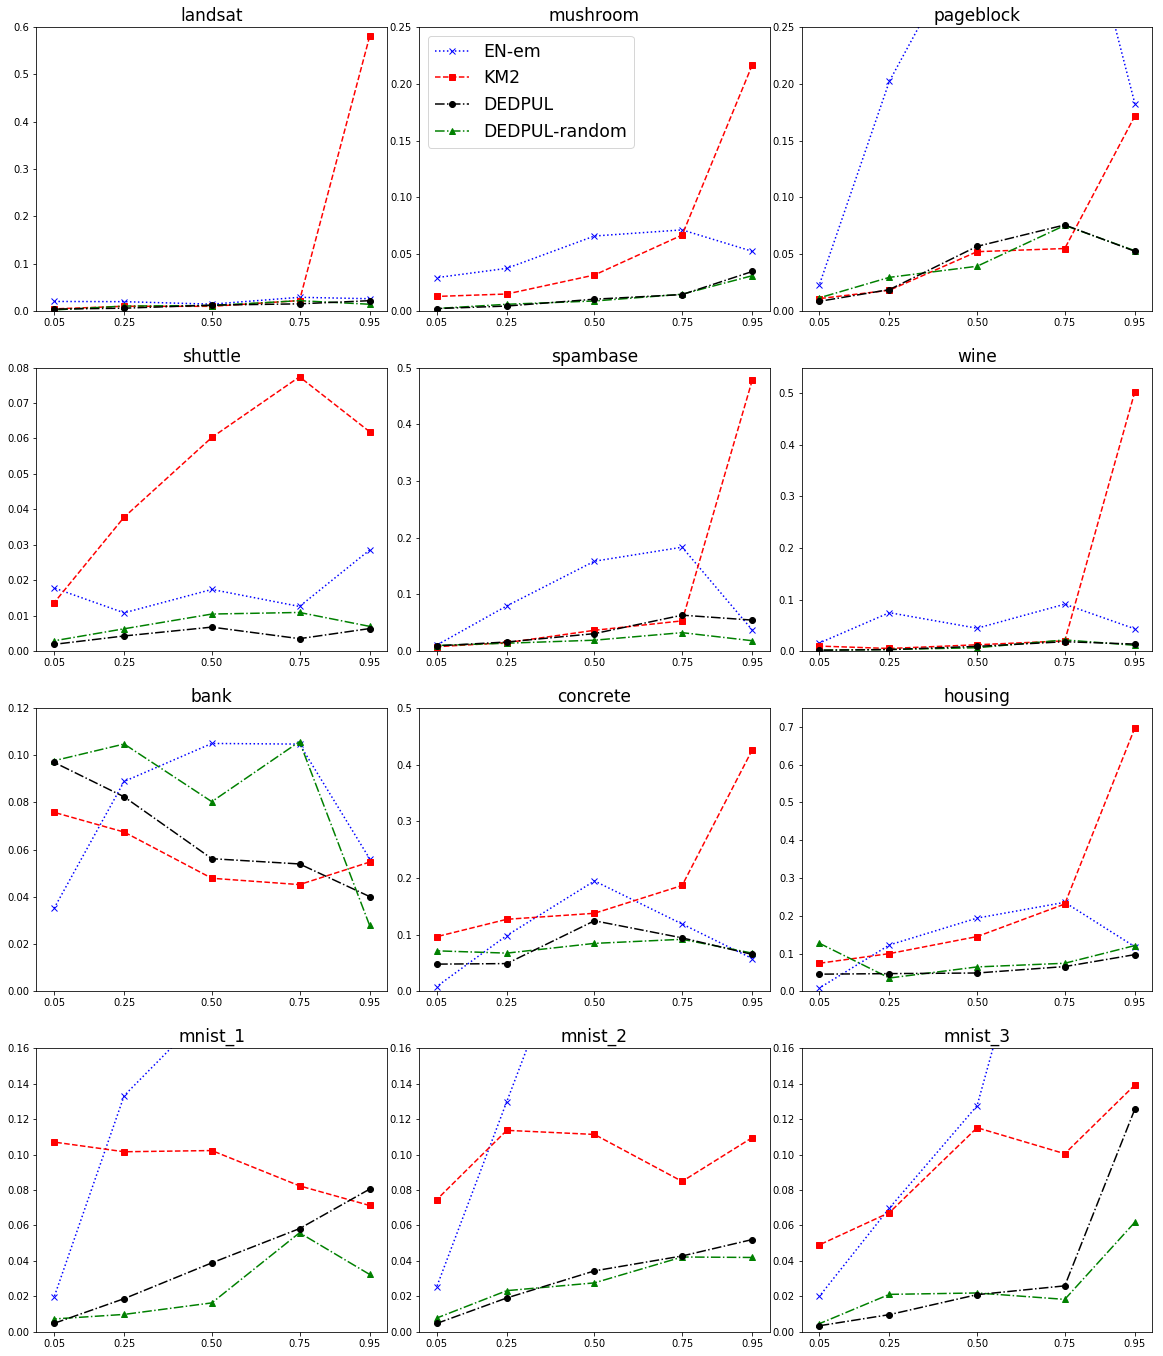

In [123]:
plot_results_alpha_uci(res_pivot_alpha.copy().reset_index(), 'all', reverse_alpha=True,
                       ylims={'bank': 0.12,
                              'concrete': 0.5,
                              'housing': 0.75,
                              'landsat': 0.6,
                              'mushroom': 0.25,
                              'pageblock': 0.25,
                              'shuttle': 0.08,
                              'spambase': 0.5,
                              'wine': 0.55,
                              'mnist_1': 0.16,
                              'mnist_2': 0.16,
                              'mnist_3': 0.16})#, save_name='uci_mnist_alpha')

## accuracy

In [10]:
def plot_results_poster_uci(res_plt, datasets='all', ylims=None, reverse_alpha=False, save_name=None, dpi=300):
    
    if reverse_alpha:
        # by default all estimates are computed for negative priors; here convert them to positive priors
        res_plt['alpha'] = 1 - res_plt['alpha']
     
    if ylims is None:
        ylims = dict()
        
    if datasets is 'uci':
        datasets = ['landsat', 'mushroom', 'pageblock', 'shuttle', 'spambase', 'wine', 'bank', 'concrete', 'housing']
        n_rows = 3
    elif datasets is 'mnist':
        datasets = ['mnist_1', 'mnist_2', 'mnist_3']
        n_rows = 1
    elif datasets is 'all':
        datasets = ['landsat', 'mushroom', 'pageblock', 'shuttle', 'spambase', 'wine', 'bank', 'concrete', 'housing',
                    'mnist_1', 'mnist_2', 'mnist_3']
        n_rows = 4
    else:
        n_rows = len(datasets) // 3
    
    fig = plt.figure(0)
    gridspec.GridSpec(n_rows,6)
    fig.set_size_inches(w=20, h=24)

    for i in range(n_rows):
        for j in range(3):
            try:
                dataset = datasets[3 * i + j]
            except:
                break
            res_plt_cur = res_plt[res_plt['dataset'] == dataset]
            plt.subplot2grid((n_rows,6), (i,2*j), colspan=2, rowspan=1)
            plt.title(dataset, fontdict={'fontsize': 17})

            plt.plot(res_plt_cur['alpha'], res_plt_cur['en'], 'bx:')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['brier_nnre'], 'ys--')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['sigmoid_nnre'], c='orange', marker='*', ls='--')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul'], 'ko-.')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['random_dedpul'], 'g^-.')
            
            plt.xlim(0, 1)
            plt.xticks(res_plt_cur['alpha'].unique())
            if dataset in ylims.keys():
                plt.ylim(0, ylims[dataset])
                
            if dataset == 'mushroom':
                plt.legend(handles=(Line2D([], [], linestyle=':', color='b', marker='x'),
                                    Line2D([], [], linestyle='--', color='y', marker='s'),
                                    Line2D([], [], linestyle='--', color='orange', marker='*'),
                                    Line2D([], [], linestyle='-.', color='k', marker='o'),
                                    Line2D([], [], linestyle='-.', color='g', marker='^')),
                                          labels=('EN', 'nnRE-brier', 'nnRE-sigmoid', 'DEDPUL', 'DEDPUL-random'),
                                          loc='upper left',
                                          fontsize='xx-large')
        
    if save_name:
        plt.savefig(save_name + '.png', dpi=dpi)

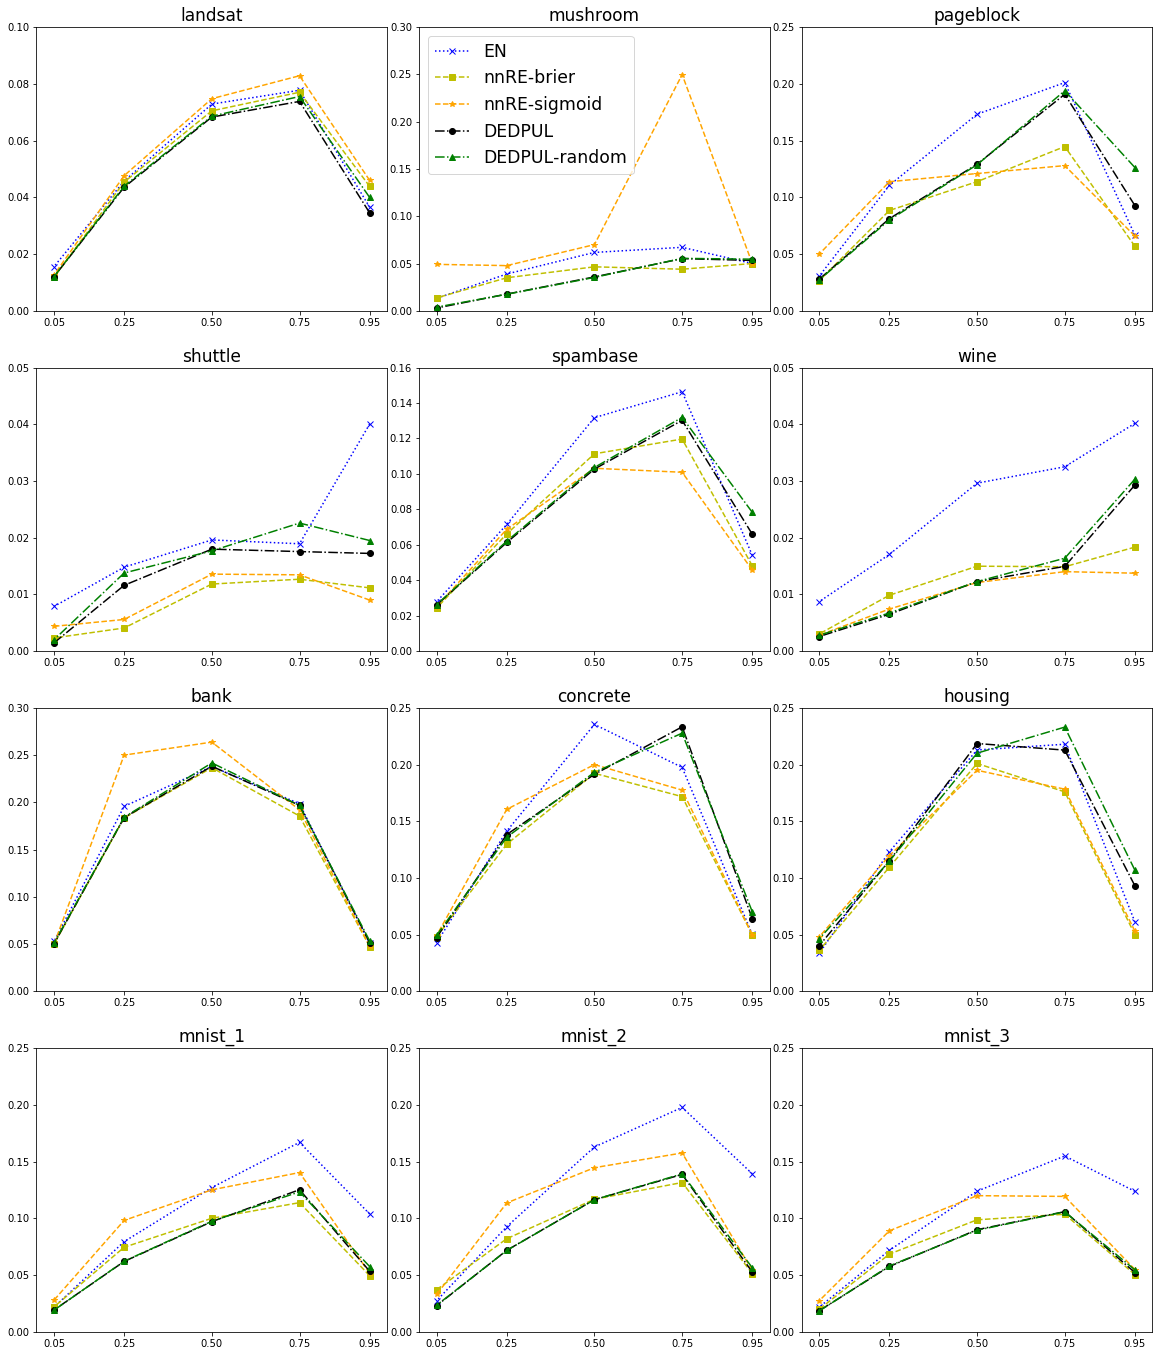

In [111]:
plot_results_poster_uci(res_pivot_roc.copy().reset_index(), 'all', reverse_alpha=True,
                        ylims={'bank': 0.3,
                              'concrete': 0.25,
                              'housing': 0.25,
                              'landsat': 0.1,
                              'mushroom': 0.3,
                              'pageblock': 0.25,
                              'shuttle': 0.05,
                              'spambase': 0.16,
                              'wine': 0.05,
                              'mnist_1': 0.25,
                              'mnist_2': 0.25,
                              'mnist_3': 0.25})#, save_name='uci_mnist_ac')